## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import json
import re
import string
from pprint import pprint
from tqdm import tqdm
from collections import Counter

# For text processing
import nltk
from nltk.corpus import stopwords
from nltk import pos_tag, word_tokenize
from nltk.stem import WordNetLemmatizer
import spacy

# For modeling
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


# For plotting
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px
from wordcloud import WordCloud


# For evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

nltk.download('stopwords') #For removing stopwords
nltk.download('punkt') # For tokenization
nltk.download('averaged_perceptron_tagger')  # For POS tagging
nltk.download('averaged_perceptron_tagger_eng') # For POS tagging
nltk.download('wordnet') # For Lemmatization


import en_core_web_sm
nlp = en_core_web_sm.load()

%matplotlib inline

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rahulmukeshsingh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/rahulmukeshsingh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/rahulmukeshsingh/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/rahulmukeshsingh/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/rahulmukeshsingh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [2]:
# Opening JSON file 
f = open('complaints-2021-05-14_08_16.json', 'r')
  
# returns JSON object as a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [3]:
# Inspect the dataframe to understand the given data.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [4]:
print('Shape of the data: ',df.shape)

Shape of the data:  (78313, 22)


In [5]:
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [6]:
# Print the column names
print("Column names: ")
for idx, col in enumerate(df.columns, start=1):
    print(f"{idx}. {col}")

Column names: 
1. _index
2. _type
3. _id
4. _score
5. _source.tags
6. _source.zip_code
7. _source.complaint_id
8. _source.issue
9. _source.date_received
10. _source.state
11. _source.consumer_disputed
12. _source.product
13. _source.company_response
14. _source.company
15. _source.submitted_via
16. _source.date_sent_to_company
17. _source.company_public_response
18. _source.sub_product
19. _source.timely
20. _source.complaint_what_happened
21. _source.sub_issue
22. _source.consumer_consent_provided


In [7]:
# Assign new column names
df.columns = [
    re.sub(r'^_', '', col).replace('source.', '')
    for col in df.columns
]
print("New column names: ")
for idx, col in enumerate(df.columns, start=1):
    print(f"{idx}. {col}")

New column names: 
1. index
2. type
3. id
4. score
5. tags
6. zip_code
7. complaint_id
8. issue
9. date_received
10. state
11. consumer_disputed
12. product
13. company_response
14. company
15. submitted_via
16. date_sent_to_company
17. company_public_response
18. sub_product
19. timely
20. complaint_what_happened
21. sub_issue
22. consumer_consent_provided


In [8]:
#Show blank rows in Complaints
blank_rows = df[df['complaint_what_happened'].str.strip() == '']
blank_rows.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A
5,complaint-public-v2,complaint,3275312,0.0,Older American,48227,3275312,Managing an account,2019-06-13T12:00:00-05:00,MI,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-14T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
6,complaint-public-v2,complaint,3238804,0.0,None,76262,3238804,Managing an account,2019-05-10T12:00:00-05:00,TX,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Phone,2019-05-10T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A


In [9]:
#Assign nan in place of blanks in the complaints column
#Replacing blank or whitespaces with nan values
df['complaint_what_happened'].replace(r'^\s*$', np.nan, regex=True, inplace=True)

In [10]:
#Remove all rows where complaints column is nan
df.dropna(subset=['complaint_what_happened'], inplace=True)
# Reset index after dropping
df.reset_index(drop=True, inplace=True)

In [11]:
print("New data shape:", df.shape)

New data shape: (21072, 22)


## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [12]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_complaint_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove content inside square, curly, and round brackets
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'\{.*?\}', '', text)
    text = re.sub(r'\(.*?\)', '', text)

    # Remove punctuation (replace any non-word, non-space character with a space)
    text = re.sub(r'[^\w\s]', '', text)

    # Remove digits
    text = re.sub(r'\w*\d\w*', '', text)
    
    # Remove extra whitespace and strip leading/trailing spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [13]:
#Write your function to Lemmatize the texts

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
def lemmatize_complaint_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stopwords
    tokens = [token for token in tokens if token.lower() not in stop_words]
    # Lemmatize each token
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    # Return as a single string
    return ' '.join(lemmatized_tokens)


In [14]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 

df_clean = pd.DataFrame()
df_clean['complaint_what_happened'] = df['complaint_what_happened']
df_clean['cleaned_lemmatized_complaints'] = df_clean['complaint_what_happened'].apply(
    lambda x: lemmatize_complaint_text(clean_complaint_text(x))
)

In [15]:
df_clean

,complaint_what_happened,cleaned_lemmatized_complaints
0,Good morning my name is XXXX XXXX and I apprec...,good morning name xxxx xxxx appreciate could h...
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgraded xxxx xxxx card told agent upgrade ann...
2,Chase Card was reported on XX/XX/2019. However...,chase card reported however fraudulent applica...
3,"On XX/XX/2018, while trying to book a XXXX XX...",trying book xxxx xxxx ticket came across offer...
4,my grand son give me check for {$1600.00} i de...,grand son give check deposit chase account fun...
...,...,...
21067,After being a Chase Card customer for well ove...,chase card customer well decade offered multip...
21068,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",wednesday xxxxxxxx called chas xxxx xxxx visa ...
21069,I am not familiar with XXXX pay and did not un...,familiar xxxx pay understand great risk provid...
21070,I have had flawless credit for 30 yrs. I've ha...,flawless credit yr ive chase credit card chase...


In [16]:
#Write your function to extract the POS tags 

def extract_only_nouns(text):
    tokens = word_tokenize(text)
    # POS tagging
    tagged_tokens = pos_tag(tokens)
    
    # Keep only singular nouns (NN)
    filtered_nouns = [word for word, tag in tagged_tokens if tag == 'NN']
    
    # Return as a single string
    return ' '.join(filtered_nouns)


# keep only tokens that have POS tag == 'NN' from already lemmatized text
df_clean["complaint_POS_removed"] =  df_clean['cleaned_lemmatized_complaints'].apply(
    lambda x: extract_only_nouns(x)
)

In [17]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaint_what_happened,cleaned_lemmatized_complaints,complaint_POS_removed
0,Good morning my name is XXXX XXXX and I apprec...,good morning name xxxx xxxx appreciate could h...,morning name appreciate chase bank cardmember ...
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgraded xxxx xxxx card told agent upgrade ann...,xxxx card agent date agent information order u...
2,Chase Card was reported on XX/XX/2019. However...,chase card reported however fraudulent applica...,chase card application identity consent servic...
3,"On XX/XX/2018, while trying to book a XXXX XX...",trying book xxxx xxxx ticket came across offer...,book ticket offer ticket card information offe...
4,my grand son give me check for {$1600.00} i de...,grand son give check deposit chase account fun...,son check deposit chase account fund chase ban...
...,...,...,...
21067,After being a Chase Card customer for well ove...,chase card customer well decade offered multip...,chase card customer decade solicitation credit...
21068,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",wednesday xxxxxxxx called chas xxxx xxxx visa ...,wednesday chas xxxx credit card provider claim...
21069,I am not familiar with XXXX pay and did not un...,familiar xxxx pay understand great risk provid...,pay risk consumer chase bank chase year trust ...
21070,I have had flawless credit for 30 yrs. I've ha...,flawless credit yr ive chase credit card chase...,flawless credit chase credit card chase freedo...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




In [18]:
# Write your code here to visualise the data according to the 'Complaint' character length
df_clean['complaint_what_happened_length'] = df_clean['complaint_what_happened'].str.len()
df_clean['cleaned_lemmatized_complaints_length'] = df_clean['cleaned_lemmatized_complaints'].str.len()
df_clean['complaint_POS_removed_length'] = df_clean['complaint_POS_removed'].str.len()

fig = go.Figure()
fig.add_trace(go.Histogram(x=df_clean['complaint_what_happened_length'], name='Complaints'))
fig.add_trace(go.Histogram(x=df_clean['cleaned_lemmatized_complaints_length'], name='Cleaned & Lemmatized Complaints'))
fig.add_trace(go.Histogram(x=df_clean['complaint_POS_removed_length'], name='POS Removed Complaints'))
fig.update_layout(barmode='overlay', title='Complaint - Character Length', xaxis_title='Character Length', yaxis_title='Count')
fig.update_traces(opacity=0.75)
fig.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

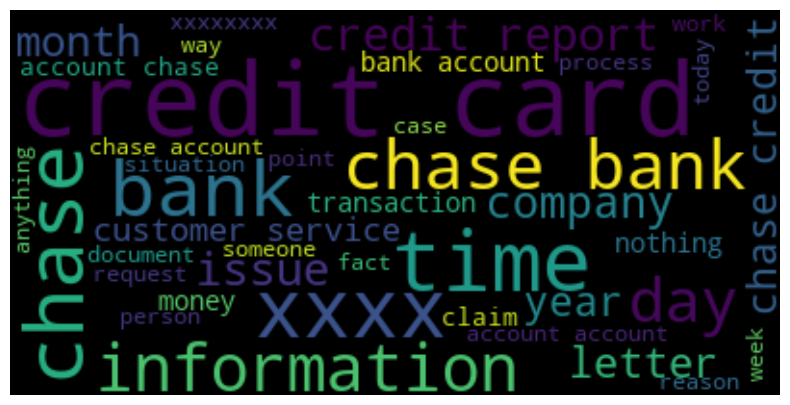

In [19]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
text_all = " ".join(df_clean['complaint_POS_removed'])
wordcloud = WordCloud(max_words=40).generate(text_all) #Top 40 words by frequency

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [20]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [21]:
# Returns the top 'top_k' most frequent n-grams (where n can be 1 for unigrams, 2 for bigrams, etc.) from a list of documents (corpus).
def get_top_ngrams(corpus, n=1, top_k=10):
    """
    Parameters:
    -----------
    corpus : list or array-like Collection of text documents.
    n : int, optional. Specifies the n-gram size (1=unigram, 2=bigram, etc.). Default is 1.
    top_k : int, optional. Number of top n-grams to return. Default is 10.

    Returns:
    --------
    list of tuples: Each tuple consists of (n-gram, frequency) sorted by descending frequency.
    """

    #CountVectorizer to extract n-grams of size n
    vectorizer = CountVectorizer(ngram_range=(n, n))
    term_matrix = vectorizer.fit_transform(corpus)

    # Sum across all documents to find the total frequency of each n-gram
    freqs = term_matrix.sum(axis=0)

    # Create (term, frequency) tuples
    freq_list = [(term, freqs[0, index]) for term, index in vectorizer.vocabulary_.items()]

    # Sort by descending frequency
    freq_list.sort(key=lambda x: x[1], reverse=True)

    #Return only the top_k n-grams
    return pd.DataFrame(freq_list[:top_k], columns=['token', 'freq'])

In [22]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).
#Get the top 30 unigrams dataframe
unigram_df = get_top_ngrams(df_clean['complaint_POS_removed'], n=1, top_k=30)
print(unigram_df)

#Create a bar plot for the top 30 unigram frequency
fig = px.bar(
    unigram_df,
    x='token',
    y='freq',
    title='Top 30 Unigrams',
    labels={'token': 'Unigram', 'freq': 'Count'}
)

#Display the figure
fig.show()

          token   freq
0         chase  52008
1       account  44540
2        credit  32565
3          bank  27766
4          card  26497
5       payment  20845
6          time  15698
7          xxxx  15655
8        charge  12789
9           day  12586
10        money  11832
11         loan  10732
12  information   9531
13       letter   9461
14        check   8856
15  transaction   8466
16       number   8309
17        month   8229
18          fee   8137
19         year   8066
20     mortgage   8063
21       amount   8055
22     customer   8043
23       report   8016
24         call   7621
25      service   7535
26      balance   7516
27      company   7510
28        phone   7367
29        claim   7343


In [23]:
#Print the top 10 words in the unigram frequency
#Get the top 10 unigrams dataframe
unigram_df_10 = unigram_df[:10]
print(unigram_df_10)

#Create a bar plot for the top 10 unigram frequency
fig = px.bar(
    unigram_df_10,
    x='token',
    y='freq',
    title='Top 10 Unigrams',
    labels={'token': 'Unigram', 'freq': 'Count'}
)

#Display the figure
fig.show()

     token   freq
0    chase  52008
1  account  44540
2   credit  32565
3     bank  27766
4     card  26497
5  payment  20845
6     time  15698
7     xxxx  15655
8   charge  12789
9      day  12586


In [24]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
#Get the top 30 bigrams dataframe
bigram_df = get_top_ngrams(df_clean['complaint_POS_removed'], n=2, top_k=30)
print(bigram_df)

#Create a bar plot for the top 30 bigram frequency
fig = px.bar(
    bigram_df,
    x='token',
    y='freq',
    title='Top 30 Bigrams',
    labels={'token': 'Bigram', 'freq': 'Count'}
)

#Display the figure
fig.show()


               token   freq
0        credit card  12494
1         chase bank   5002
2      credit report   3849
3       chase credit   3104
4   customer service   3049
5       bank account   2855
6      chase account   2725
7      account chase   2666
8    account account   2472
9       account bank   1733
10        phone call   1606
11      card account   1586
12      credit score   1556
13      letter chase   1482
14        card chase   1478
15    account credit   1476
16   payment payment   1381
17     credit bureau   1284
18     money account   1270
19     interest rate   1262
20      business day   1228
21      phone number   1199
22    account number   1111
23      card company   1109
24     payment chase   1093
25        debit card   1057
26        chase card   1054
27  fraud department   1044
28  mortgage payment   1044
29    charge account   1013


In [25]:
#Print the top 10 words in the bigram frequency
#Get the top 10 bigrams dataframe
bigram_df_10 = bigram_df[:10]
print(bigram_df_10)

#Create a bar plot for the top 10 bigram frequency
fig = px.bar(
    bigram_df_10,
    x='token',
    y='freq',
    title='Top 10 Bigrams',
    labels={'token': 'Bigram', 'freq': 'Count'}
)

#Display the figure
fig.show()

              token   freq
0       credit card  12494
1        chase bank   5002
2     credit report   3849
3      chase credit   3104
4  customer service   3049
5      bank account   2855
6     chase account   2725
7     account chase   2666
8   account account   2472
9      account bank   1733


In [26]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
#Get the top 30 trigrams dataframe
trigram_df = get_top_ngrams(df_clean['complaint_POS_removed'], n=3, top_k=30)
print(trigram_df)

#Create a bar plot for the top 30 trigram frequency
fig = px.bar(
    trigram_df,
    x='token',
    y='freq',
    title='Top 30 Trigram',
    labels={'token': 'Trigram', 'freq': 'Count'}
)

#Display the figure
fig.show()

                         token  freq
0            chase credit card  2097
1          credit card account  1035
2          credit card company   990
3            credit card chase   723
4           credit card credit   541
5        inquiry credit report   438
6           chase bank account   432
7           charge credit card   402
8         credit report credit   398
9          account credit card   392
10            card credit card   389
11            bank credit card   378
12     credit reporting agency   369
13      chase customer service   364
14            credit card bank   344
15       account credit report   329
16        credit reporting act   323
17         credit card payment   298
18       account chase account   284
19            phone call chase   264
20          credit card charge   253
21         credit card balance   252
22      chase fraud department   248
23  consumer protection bureau   247
24           chase bank credit   235
25         freedom credit card   230
2

In [27]:
#Print the top 10 words in the trigram frequency
#Get the top 10 trigrams dataframe
trigram_df_10 = trigram_df[:10]
print(trigram_df_10)

#Create a bar plot for the top 10 trigram frequency
fig = px.bar(
    trigram_df_10,
    x='token',
    y='freq',
    title='Top 10 Trigrams',
    labels={'token': 'Trigram', 'freq': 'Count'}
)

#Display the figure
fig.show()

                   token  freq
0      chase credit card  2097
1    credit card account  1035
2    credit card company   990
3      credit card chase   723
4     credit card credit   541
5  inquiry credit report   438
6     chase bank account   432
7     charge credit card   402
8   credit report credit   398
9    account credit card   392


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [28]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [29]:
#All masked texts has been removed
df_clean

,complaint_what_happened,cleaned_lemmatized_complaints,complaint_POS_removed,complaint_what_happened_length,cleaned_lemmatized_complaints_length,complaint_POS_removed_length,Complaint_clean
0,Good morning my name is XXXX XXXX and I apprec...,good morning name xxxx xxxx appreciate could h...,morning name appreciate chase bank cardmember ...,486,322,161,morning name appreciate chase bank cardmember ...
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgraded xxxx xxxx card told agent upgrade ann...,xxxx card agent date agent information order u...,355,224,84,card agent date agent information order upgra...
2,Chase Card was reported on XX/XX/2019. However...,chase card reported however fraudulent applica...,chase card application identity consent servic...,224,164,73,chase card application identity consent servic...
3,"On XX/XX/2018, while trying to book a XXXX XX...",trying book xxxx xxxx ticket came across offer...,book ticket offer ticket card information offe...,1502,893,373,book ticket offer ticket card information offe...
4,my grand son give me check for {$1600.00} i de...,grand son give check deposit chase account fun...,son check deposit chase account fund chase ban...,477,299,188,son check deposit chase account fund chase ban...
...,...,...,...,...,...,...,...
21067,After being a Chase Card customer for well ove...,chase card customer well decade offered multip...,chase card customer decade solicitation credit...,679,434,219,chase card customer decade solicitation credit...
21068,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",wednesday xxxxxxxx called chas xxxx xxxx visa ...,wednesday chas xxxx credit card provider claim...,2114,1334,611,wednesday chas credit card provider claim pur...
21069,I am not familiar with XXXX pay and did not un...,familiar xxxx pay understand great risk provid...,pay risk consumer chase bank chase year trust ...,2319,1505,629,pay risk consumer chase bank chase year trust ...
21070,I have had flawless credit for 30 yrs. I've ha...,flawless credit yr ive chase credit card chase...,flawless credit chase credit card chase freedo...,2171,1183,505,flawless credit chase credit card chase freedo...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [30]:
#Write your code here to initialise the TfidfVectorizer 
tf_idf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')


#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [31]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
tf_idf_matrix = tf_idf_vectorizer.fit_transform(df_clean['Complaint_clean'])

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [32]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [33]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)

In [34]:
nmf_model.fit(tf_idf_matrix) #Fit the NMF model on the document-term matrix (dtm)
len(tf_idf_vectorizer.get_feature_names_out()) #number of unique tokens/features in the vocabulary

6897

In [35]:
#Print the Top15 words for each of the topics
#number of top words to display per topic
top_n = 15

#Iterate over each topic in the NMF model
for topic_idx, topic in enumerate(nmf_model.components_):
    # Get the indices of the top 'top_n' words for this topic
    top_indices = topic.argsort()[-top_n:][::-1]
    # Map indices to words using the tf-idf vectorizer's feature names
    top_words = [tf_idf_vectorizer.get_feature_names_out()[i] for i in top_indices]
    print(f"Topic #{topic_idx}: {top_words}")

Topic #0: ['account', 'bank', 'check', 'money', 'chase', 'fund', 'deposit', 'day', 'branch', 'number', 'business', 'transaction', 'transfer', 'customer', 'claim']
Topic #1: ['credit', 'card', 'report', 'inquiry', 'chase', 'account', 'company', 'score', 'bureau', 'limit', 'debt', 'information', 'application', 'letter', 'balance']
Topic #2: ['payment', 'balance', 'month', 'fee', 'statement', 'pay', 'day', 'time', 'chase', 'auto', 'date', 'credit', 'year', 'car', 'mortgage']
Topic #3: ['charge', 'card', 'chase', 'transaction', 'dispute', 'fraud', 'fee', 'merchant', 'claim', 'purchase', 'service', 'time', 'statement', 'refund', 'company']
Topic #4: ['loan', 'mortgage', 'home', 'chase', 'modification', 'property', 'year', 'rate', 'letter', 'time', 'bank', 'house', 'foreclosure', 'sale', 'document']


In [36]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
# topic distribution for each complaint
topic_distributions = nmf_model.transform(tf_idf_matrix)


In [37]:
#Assign the best topic to each of the cmplaints in Topic Column
df_clean['Topic'] = topic_distributions.argmax(axis=1)

In [38]:
df_clean.head()

,complaint_what_happened,cleaned_lemmatized_complaints,complaint_POS_removed,complaint_what_happened_length,cleaned_lemmatized_complaints_length,complaint_POS_removed_length,Complaint_clean,Topic
0,Good morning my name is XXXX XXXX and I apprec...,good morning name xxxx xxxx appreciate could h...,morning name appreciate chase bank cardmember ...,486,322,161,morning name appreciate chase bank cardmember ...,0
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgraded xxxx xxxx card told agent upgrade ann...,xxxx card agent date agent information order u...,355,224,84,card agent date agent information order upgra...,1
2,Chase Card was reported on XX/XX/2019. However...,chase card reported however fraudulent applica...,chase card application identity consent servic...,224,164,73,chase card application identity consent servic...,1
3,"On XX/XX/2018, while trying to book a XXXX XX...",trying book xxxx xxxx ticket came across offer...,book ticket offer ticket card information offe...,1502,893,373,book ticket offer ticket card information offe...,1
4,my grand son give me check for {$1600.00} i de...,grand son give check deposit chase account fun...,son check deposit chase account fund chase ban...,477,299,188,son check deposit chase account fund chase ban...,0


In [39]:
#Print the first 5 Complaint for each of the Topics
df_clean=df_clean.groupby('Topic').head(2)
df_clean.sort_values('Topic')

,complaint_what_happened,cleaned_lemmatized_complaints,complaint_POS_removed,complaint_what_happened_length,cleaned_lemmatized_complaints_length,complaint_POS_removed_length,Complaint_clean,Topic
0,Good morning my name is XXXX XXXX and I apprec...,good morning name xxxx xxxx appreciate could h...,morning name appreciate chase bank cardmember ...,486,322,161,morning name appreciate chase bank cardmember ...,0
4,my grand son give me check for {$1600.00} i de...,grand son give check deposit chase account fun...,son check deposit chase account fund chase ban...,477,299,188,son check deposit chase account fund chase ban...,0
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgraded xxxx xxxx card told agent upgrade ann...,xxxx card agent date agent information order u...,355,224,84,card agent date agent information order upgra...,1
2,Chase Card was reported on XX/XX/2019. However...,chase card reported however fraudulent applica...,chase card application identity consent servic...,224,164,73,chase card application identity consent servic...,1
7,"During the summer months, I experience a decli...",summer month experience decline income due emp...,summer month experience income employment mont...,1396,1002,564,summer month experience income employment mont...,2
24,I made a purchase of {$260.00} on XX/XX/XXXX. ...,made purchase xxxxxxxx made payment xxxxxxxx x...,purchase xxxxxxxx payment payment closing date...,1274,686,340,purchase payment payment closing date stateme...,2
8,"On XXXX XX/XX/2019, I made a {$300.00} payment...",xxxx made payment online retailer using chase ...,xxxx payment online retailer pay chase website...,3541,2108,1110,payment online retailer pay chase website con...,3
13,"To whom it may concern, Chase bank charged wro...",may concern chase bank charged wrongly overdra...,concern bank fee alert balance fee balance tra...,566,376,158,concern bank fee alert balance fee balance tra...,3
18,Chase sent me an email today with the innocuou...,chase sent email today innocuous title importa...,chase email today title information change cha...,934,396,189,chase email today title information change cha...,4
23,I have been trying to do a loan modification w...,trying loan modification chase give runaround ...,loan modification chase runaround im mo payment,190,103,47,loan modification chase runaround im mo payment,4


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [40]:
#Create the dictionary of Topic names and Topics

Topic_names = {
    0: 'Bank Account services',
    1: 'Credit card or prepaid card',
    2: 'Others',
    3: 'Theft/Dispute Reporting',
    4: 'Mortgage/Loan'
}

#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [41]:
df_clean

,complaint_what_happened,cleaned_lemmatized_complaints,complaint_POS_removed,complaint_what_happened_length,cleaned_lemmatized_complaints_length,complaint_POS_removed_length,Complaint_clean,Topic
0,Good morning my name is XXXX XXXX and I apprec...,good morning name xxxx xxxx appreciate could h...,morning name appreciate chase bank cardmember ...,486,322,161,morning name appreciate chase bank cardmember ...,Bank Account services
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgraded xxxx xxxx card told agent upgrade ann...,xxxx card agent date agent information order u...,355,224,84,card agent date agent information order upgra...,Credit card or prepaid card
2,Chase Card was reported on XX/XX/2019. However...,chase card reported however fraudulent applica...,chase card application identity consent servic...,224,164,73,chase card application identity consent servic...,Credit card or prepaid card
4,my grand son give me check for {$1600.00} i de...,grand son give check deposit chase account fun...,son check deposit chase account fund chase ban...,477,299,188,son check deposit chase account fund chase ban...,Bank Account services
7,"During the summer months, I experience a decli...",summer month experience decline income due emp...,summer month experience income employment mont...,1396,1002,564,summer month experience income employment mont...,Others
8,"On XXXX XX/XX/2019, I made a {$300.00} payment...",xxxx made payment online retailer using chase ...,xxxx payment online retailer pay chase website...,3541,2108,1110,payment online retailer pay chase website con...,Theft/Dispute Reporting
13,"To whom it may concern, Chase bank charged wro...",may concern chase bank charged wrongly overdra...,concern bank fee alert balance fee balance tra...,566,376,158,concern bank fee alert balance fee balance tra...,Theft/Dispute Reporting
18,Chase sent me an email today with the innocuou...,chase sent email today innocuous title importa...,chase email today title information change cha...,934,396,189,chase email today title information change cha...,Mortgage/Loan
23,I have been trying to do a loan modification w...,trying loan modification chase give runaround ...,loan modification chase runaround im mo payment,190,103,47,loan modification chase runaround im mo payment,Mortgage/Loan
24,I made a purchase of {$260.00} on XX/XX/XXXX. ...,made purchase xxxxxxxx made payment xxxxxxxx x...,purchase xxxxxxxx payment payment closing date...,1274,686,340,purchase payment payment closing date stateme...,Others


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [42]:
#Create the dictionary again of Topic names and Topics

Topic_names = {
    'Bank Account services':0,
    'Credit card or prepaid card':1,
    'Others':2,
    'Theft/Dispute Reporting':3,
    'Mortgage/Loan':4
}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [43]:
df_clean

,complaint_what_happened,cleaned_lemmatized_complaints,complaint_POS_removed,complaint_what_happened_length,cleaned_lemmatized_complaints_length,complaint_POS_removed_length,Complaint_clean,Topic
0,Good morning my name is XXXX XXXX and I apprec...,good morning name xxxx xxxx appreciate could h...,morning name appreciate chase bank cardmember ...,486,322,161,morning name appreciate chase bank cardmember ...,0
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgraded xxxx xxxx card told agent upgrade ann...,xxxx card agent date agent information order u...,355,224,84,card agent date agent information order upgra...,1
2,Chase Card was reported on XX/XX/2019. However...,chase card reported however fraudulent applica...,chase card application identity consent servic...,224,164,73,chase card application identity consent servic...,1
4,my grand son give me check for {$1600.00} i de...,grand son give check deposit chase account fun...,son check deposit chase account fund chase ban...,477,299,188,son check deposit chase account fund chase ban...,0
7,"During the summer months, I experience a decli...",summer month experience decline income due emp...,summer month experience income employment mont...,1396,1002,564,summer month experience income employment mont...,2
8,"On XXXX XX/XX/2019, I made a {$300.00} payment...",xxxx made payment online retailer using chase ...,xxxx payment online retailer pay chase website...,3541,2108,1110,payment online retailer pay chase website con...,3
13,"To whom it may concern, Chase bank charged wro...",may concern chase bank charged wrongly overdra...,concern bank fee alert balance fee balance tra...,566,376,158,concern bank fee alert balance fee balance tra...,3
18,Chase sent me an email today with the innocuou...,chase sent email today innocuous title importa...,chase email today title information change cha...,934,396,189,chase email today title information change cha...,4
23,I have been trying to do a loan modification w...,trying loan modification chase give runaround ...,loan modification chase runaround im mo payment,190,103,47,loan modification chase runaround im mo payment,4
24,I made a purchase of {$260.00} on XX/XX/XXXX. ...,made purchase xxxxxxxx made payment xxxxxxxx x...,purchase xxxxxxxx payment payment closing date...,1274,686,340,purchase payment payment closing date stateme...,2


In [44]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[["complaint_what_happened","Topic"]]

In [45]:
training_data

,complaint_what_happened,Topic
0,Good morning my name is XXXX XXXX and I apprec...,0
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,1
2,Chase Card was reported on XX/XX/2019. However...,1
4,my grand son give me check for {$1600.00} i de...,0
7,"During the summer months, I experience a decli...",2
8,"On XXXX XX/XX/2019, I made a {$300.00} payment...",3
13,"To whom it may concern, Chase bank charged wro...",3
18,Chase sent me an email today with the innocuou...,4
23,I have been trying to do a loan modification w...,4
24,I made a purchase of {$260.00} on XX/XX/XXXX. ...,2


#### Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [46]:

#Write your code to get the Vector count
count_vectorizer = CountVectorizer()
X_train_counts = count_vectorizer.fit_transform(training_data['complaint_what_happened'])

#Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [47]:
X_train, X_test, y_train, y_test = train_test_split(
    X_train_tfidf,        # Feature matrix (TF-IDF vectors of the training data)
    training_data['Topic'],  # Labels/targets (topics for each document)
    test_size=0.2,       # 20% data for testing, 80% for training
    random_state=40       # Seed for reproducible split
)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [48]:
# Write your code here to build any 3 models and evaluate them using the required metrics



